# Support Vector Machines (SVMs)

# Introduction

[Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine) algorithm stands out as a potent tool in supervised machine learning, adept at tackling both regression and classification tasks. It comprises two main categories: linear SVM, suitable for linearly separable data, and non-linear SVM, applicable to data with non-linear separations.

By crafting an optimal decision boundary, SVM distinguishes itself in class segregation. It determines this boundary by maximizing the distance between the closest points of distinct classes, termed support vectors. The space delineated by these support vectors constitutes the margin, defining the region where classification decisions are made.

### Generalized Algorithm:
- Place each data point in an N-dimensional space, where N denotes the number of features or attributes within the dataset.
- Identify the optimal hyperplane for effectively separating the data. This involves utilizing **support vectors**, which are data points situated closer to the hyperplane. These support vectors play a crucial role in determining the position and orientation of the hyperplane. Maximizing the margin of the classifier is achieved by leveraging these support vectors. Any modifications to or deletion of these support vectors can lead to changes in the position of the hyperplane.


![image](https://miro.medium.com/max/1050/0*ecA4Ls8kBYSM5nza.jpg)

- Weights update function (using gradients)

![image](https://miro.medium.com/max/1050/1*WUphtYLfTOAoaXQXvImBeA.png)

which becomes

![image](https://miro.medium.com/max/462/1*-nKEXrWos8Iuf-DWSv_srQ.png)

for when there is *no misclassification* (i.e. our model correctly predicts the class of our data points, so we only have to update the gradient from the regularization parameter), and 

![image](https://miro.medium.com/max/642/1*tnvMhAKaTUCO43diEvtTAQ.png)

when there has been a *misclassification* (i.e. the model made a mistake on the prediction of the class of a datapoint, so we need to include the loss along with the regularization parameter to perform the gradient update).

- Consider the result of the linear function: if the output surpasses 1, we assign it to one class; if it falls to -1, we associate it with another class.

Cost function: our objective is to enhance the margin between data points and the hyperplane. Hence, we employ hinge loss, depicted as a piecewise function on the left and a function on the right, to achieve this goal.

![image](https://miro.medium.com/max/1624/1*hHlytjVk6d7O2WWvG2Gdig.png)

Final cost function:

![image](https://miro.medium.com/max/1400/1*GQAd28bK8LKOL2kOOFY-tg.png)

**Kernelized SVM**

This method allows a nonlinear function to separate the dataset. It maps each datapoint into a higher dimension, exemplified below:

![image](https://miro.medium.com/max/1400/1*ZpkLQf2FNfzfH4HXeMw4MQ.png)

- kernel: measure of similarity between datapoints
- kernel function: it unveils the likeness between two data points within the newly configured feature space. Various kernel function choices exist:
  - **Redial Basis Function Kernel (RBF):** Within the transformed feature space, the similarity between two points is portrayed as an exponentially diminishing function of the distance between the vectors and the original input space. RBF serves as the default kernel employed in SVM.

![image](https://user-images.githubusercontent.com/89811204/146305418-93423376-1086-4f5f-a0e9-9c099d7c3132.png)

  - **Polynomial Kernel:** takes an additional parameter, "degree" that controls the model's complexity and computational cost of the transformation
  - **Kernel Trick:** The actual conversion of points to the new, higher-dimensional space isn't always required. Despite the intricacy of the process, in straightforward terms, kernelized SVM can internally execute these intricate transformations solely through similarity assessments between pairs of points in the higher-dimensional feature space, where the transformed feature representation is implicit. This similarity function, essentially a form of complex dot product, serves as the kernel of a kernelized SVM. Consequently, this approach enables the practical application of SVM, even when the underlying feature space is complex or potentially infinite-dimensional.

For more information refer to [this article](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47).


---

## Implementation

This notebook demonstrates the implementation of SVM to train a classifier for the automatic annotation of single-cell RNA-seq data. The training dataset comprises expert-annotated data. 

### About the Dataset

The Processed 3k Peripheral Blood Mononuclear Cells (PBMCs) Dataset consists of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics. There are 2,700 single cells that were sequenced on the Illumina NextSeq 500. 

### Tools

The following libraries are used in the notebook:

* [matplotlib](http://metplotlib.org)
* [pandas](http://pandas.pydata.org)
* [numpy](https://numpy.org/doc/stable/index.html)
* [seaborn](https://seaborn.pydata.org/)
* [scanpy](https://scanpy.readthedocs.io/en/stable/)
* [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split) in [sklearn.model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) and [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC) in [sklearn.svm](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
* [CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html?highlight=calibratedclassifiercv#sklearn.calibration.CalibratedClassifierCV) in [sklearn.calibration](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.calibration)
* [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion_matrix#sklearn.metrics.confusion_matrix) in [sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler) in [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
* [scipy.sparse.linalg](https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html)

The [Processed 3k PBMCs](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k_processed.html) Dataset is loaded from [scanpy.datasets](https://scanpy.readthedocs.io/en/stable/api.html#module-scanpy.datasets).

In [29]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import scipy.sparse.linalg

### Data Exploration

The data used in the notebook is publicly available in scanpy package (the most popular single-cell framework in python). This dataset contains over 2000 human peripheral blood mononuclear cells.

In [30]:
adata = sc.datasets.pbmc3k_processed().raw.to_adata()

In [31]:
# print the data structure
print(adata)

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    obsp: 'distances', 'connectivities'


Let's take a look at meta data for the observes (cells).
The louvain column is the cell annotation (expert annotated from louvain clustering results).

In [32]:
adata.obs

,n_genes,percent_mito,n_counts,louvain
index,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells
...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells


The aim is to utilize an SVM classifier for the automated annotation of cells. Given that single-cell data is sparse and encompasses numerous features, typically ranging from 10,000 to 20,000, initial dimensional reduction is imperative, often achieved through PCA. Additionally, we seek to conduct PCA using a relatively limited set of genes, such as 2,000. In this context, we employ the built-in functionality of scanpy to compute the top_n variable genes.

In [33]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=2000)
# We then only focus on these 2000 features (genes)
adata = adata[:, adata.var.highly_variable]

In [34]:
# Get the predictors (genes here; we will then do PCA)
X = adata.X
# The targets
Y = adata.obs['louvain']
Y.to_numpy()
# Split the training and testing set
X_train,X_val,y_train,y_val = train_test_split(X,Y,test_size=0.3, stratify=Y)

### Algorithm Implementation

In [35]:
# define a pca function
# pca for sparse matrix; modified from https://gist.github.com/julienr/8096321
def pca_sparse(X, npc):
    n_samples, n_features = X.shape
    Xmean = np.mean(X, axis=0)
    U, s, Vt = scipy.sparse.linalg.svds(X - Xmean, k=npc)
    order = np.argsort(-s) # sort s in descending order

    # svds returns U, s, Vt sorder in ascending order. We want descending
    s = s[order]
    W = Vt[order,:]
    U = U[:, order]

    explained_variance = (s**2) / float(n_samples)
    exp_var_ratio = explained_variance / explained_variance.sum()

    return U, s, W, exp_var_ratio

In [36]:
# do PCA with 50 dims
p = pca_sparse(X=X_train, npc=50)
# 
V = p[2].T
Us = np.matmul(p[0], np.diag(p[1]))
exp_var_thresh = 0.01
Us_sig = Us[:, p[3] > exp_var_thresh]

In [37]:
# check dimensions of Us_sig and V matrices; here we see top 8 dimensions can explain over 99% of variance
print(Us_sig.shape)
print(V.shape)

(1846, 7)
(2000, 50)


In [38]:
# project X_val to the same space
# get projection matrix
V_sig = V[:, p[3] > exp_var_thresh]
# center X_val
X_val_mean = np.mean(X_val, axis=0)
X_val_c = X_val - X_val_mean
# projection
X_val_p = np.matmul(X_val_c, V_sig)

In [39]:
# train
Classifier = SVC(kernel='rbf',gamma='scale',decision_function_shape='ovr')
clf = CalibratedClassifierCV(Classifier)
clf.fit(Us_sig, y_train)

CalibratedClassifierCV(estimator=SVC())

In [40]:
# Convert X_val_p to a numpy array
X_val_p_array = np.asarray(X_val_p)

# Predict
predicted = clf.predict(X_val_p_array)

# Compute probability
prob = np.max(clf.predict_proba(X_val_p_array), axis=1)

# Label the cells with ambiguous prediction as 'Unknown'
unlabeled = np.where(prob < 0.5)
predicted[unlabeled] = 'Unknown'

In [41]:
# # predict
# predicted = clf.predict(X_val_p)
# # compute probability
# prob = np.max(clf.predict_proba(X_val_p), axis = 1)
# # label the cells with ambiguous prediction as 'Unknown'
# # ambiguous means its max prediction probability is less than a threshold; used 0.5 here
# unlabeled = np.where(prob < 0.5)
# predicted[unlabeled] = 'Unknown'

### Build the confusion matrix

In [42]:
x_actual = pd.Series(y_val.to_numpy(), name='Actual')
x_predicted = pd.Series(predicted, name='Predicted')
df_confusion = pd.crosstab(x_actual, x_predicted)

### Visualization

<Axes: xlabel='Predicted', ylabel='Actual'>

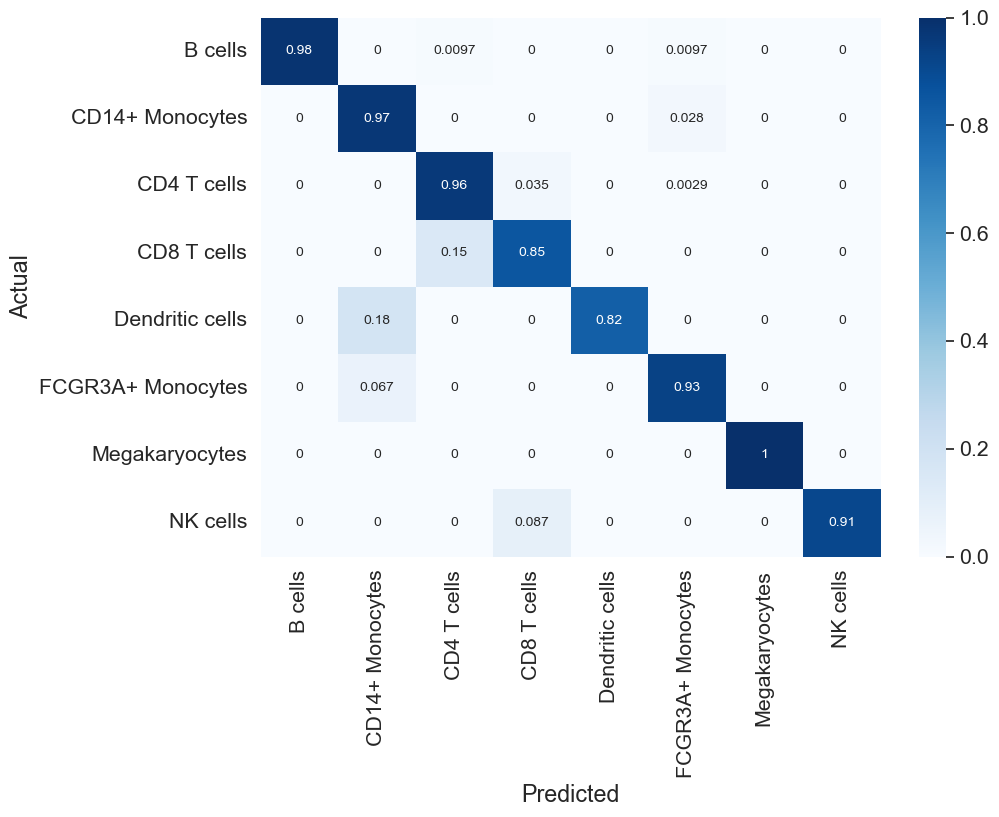

In [43]:
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_confusion.div(df_confusion.sum(axis=1), axis=0), cmap="Blues", annot=True,annot_kws={"size": 10})